In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px
import statistics as st

from scipy.stats import shapiro, jarque_bera, norm
import statsmodels.api as sm
from statsmodels.stats.diagnostic import acorr_ljungbox

In [3]:

def get_df(day):
    file_name = f"./round-3-island-data-bottle/prices_round_3_day_{day}.csv"
    return pd.read_csv(file_name, sep=';')

def get_product(df, product):
    return df[df['product'] == product].copy()

def get_first_two_dfs():
    first_df = get_df(1)
    second_df = get_df(2)
    second_df['timestamp'] = second_df['timestamp'] + 1000000
    return pd.concat([first_df, second_df])


In [4]:
volume_cut = 15

In [5]:
day1_df = get_df(1)
day1_product_df = get_product(day1_df, 'SQUID_INK')

def calc_adj_mid_price_1(row):
    weight_sum = 0;
    total_volume = 0;
    for i in range(1,4):
        weight_sum += row[f'bid_volume_{i}'] * row[f'bid_price_{i}']
        weight_sum += row[f'ask_volume_{i}'] * row[f'ask_price_{i}']
        total_volume += row[f'bid_volume_{i}']
        total_volume += row[f'ask_volume_{i}']
        
        return weight_sum / total_volume
    
def calc_adj_mid_price_2(row):
    weight_sum = 0;
    total_volume = 0;
    for i in range(1,4):
        weight_sum += row[f'bid_volume_{i}'] * row[f'bid_price_{i}'] if row[f'bid_volume_{i}'] > volume_cut else 0
        weight_sum += row[f'ask_volume_{i}'] * row[f'ask_price_{i}'] if row[f'ask_volume_{i}'] > volume_cut else 0
        total_volume += row[f'bid_volume_{i}'] if row[f'bid_volume_{i}'] > volume_cut else 0
        total_volume += row[f'ask_volume_{i}'] if row[f'ask_volume_{i}'] > volume_cut else 0
        
        return weight_sum / total_volume if total_volume != 0 else calc_adj_mid_price_1(row)
    
def calc_adj_mid_price_hard(row):
    weight_sum = 0;
    total_weight = 0;
    for i in range(1,4):
        weight_sum += row[f'bid_price_{i}'] if row[f'bid_volume_{i}'] > volume_cut else 0
        weight_sum += row[f'ask_price_{i}'] if row[f'ask_volume_{i}'] > volume_cut else 0
        total_weight += 1 if row[f'bid_volume_{i}'] > volume_cut else 0
        total_weight += 1 if row[f'ask_volume_{i}'] > volume_cut else 0
        
        return weight_sum / total_weight if total_weight != 0 else calc_adj_mid_price_1(row)

In [6]:
def check_gbm(time_series, alpha=0.05):
    """
    Check if a time series is compatible with a geometric Brownian motion.

    Parameters:
        time_series (np.array): 1D array of prices.
        alpha (float): Significance level for hypothesis tests.

    Returns:
        dict: Dictionary of test results for normality and independence.
    """
    results = {}

    # 1. Log transform the series so that: X_t = log(S_t)
    log_series = np.log(time_series)

    # 2. Compute the log returns (increments): ΔX_t = X_t+Δt - X_t
    log_returns = np.diff(log_series)

    # 3. Test for normality
    #    a. Shapiro-Wilk test
    shapiro_stat, shapiro_p = shapiro(log_returns)
    results['Shapiro-Wilk'] = {'statistic': shapiro_stat, 'p-value': shapiro_p,
                               'normality': shapiro_p > alpha}

    #    b. Jarque-Bera test
    jb_stat, jb_p = jarque_bera(log_returns)
    results['Jarque-Bera'] = {'statistic': jb_stat, 'p-value': jb_p,
                              'normality': jb_p > alpha}

    # 4. Test for independence (no autocorrelation) using the Ljung-Box test
    #    Here we test at a fixed lag (e.g., 10). Adjust lags as needed.
    lb_test = acorr_ljungbox(log_returns, lags=[50], return_df=True)
    lb_p_value = lb_test['lb_pvalue'].iloc[-1]
    results['Ljung-Box'] = {'lag': 50, 'p-value': lb_p_value,
                            'independence': lb_p_value > alpha}

    # 5. Diagnostic plots
    #    a. QQ-plot to assess normality
    sm.qqplot(log_returns, line='45', fit=True)
    plt.title('QQ-Plot of Log Returns')
    plt.show()


    #    b. Histogram with fitted normal distribution
    plt.hist(log_returns, bins=30, density=True,
             alpha=0.6, color='skyblue', edgecolor='k')
    mu, sigma = np.mean(log_returns), np.std(log_returns)
    x_vals = np.linspace(log_returns.min(), log_returns.max(), 100)
    plt.plot(x_vals, norm.pdf(x_vals, mu, sigma), 'r', lw=2)
    plt.title('Histogram of Log Returns')
    plt.xlabel('Log Return')
    plt.ylabel('Density')
    plt.show()

    return results

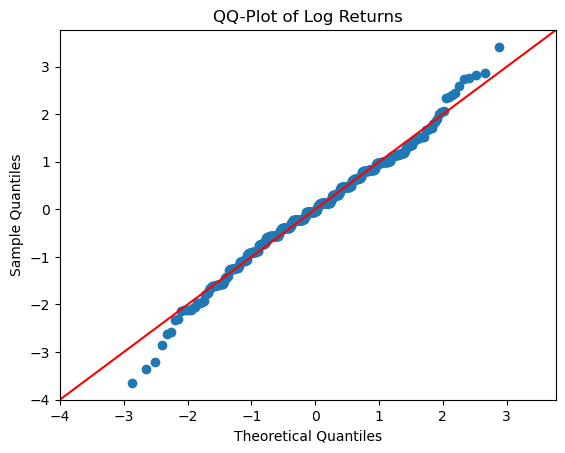

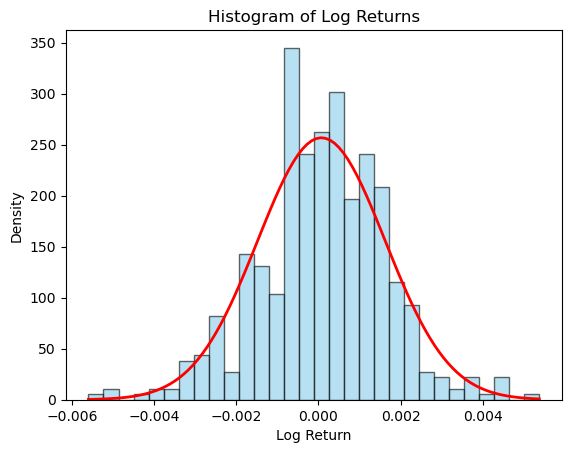

Shapiro-Wilk: {'statistic': 0.9902500655305488, 'p-value': 0.002181504155263035, 'normality': False}
Jarque-Bera: {'statistic': 15.527547225377843, 'p-value': 0.0004248503313091213, 'normality': False}
Ljung-Box: {'lag': 50, 'p-value': 0.5663546097883705, 'independence': True}


In [7]:
day1_product_df['adj_mid_price'] = day1_product_df.apply(calc_adj_mid_price_2, axis = 1)

# day1_product_df.plot(x='timestamp',y='mid_price')
# day1_product_df.plot(x='timestamp',y='adj_mid_price')
# plt.show()

mid_pirce_series = day1_product_df['adj_mid_price'].to_numpy()
# plt.plot(np.diff(np.log(mid_pirce_series)))

test_results = check_gbm(mid_pirce_series[5000:5500])
for test, res in test_results.items():
    print(f"{test}: {res}")

/opt/anaconda3/lib/python3.12/site-packages/scipy/stats/_axis_nan_policy.py:531: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 9999.
  res = hypotest_fun_out(*samples, **kwds)


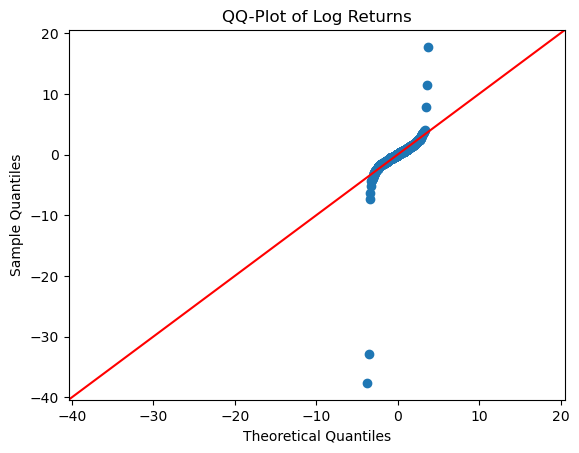

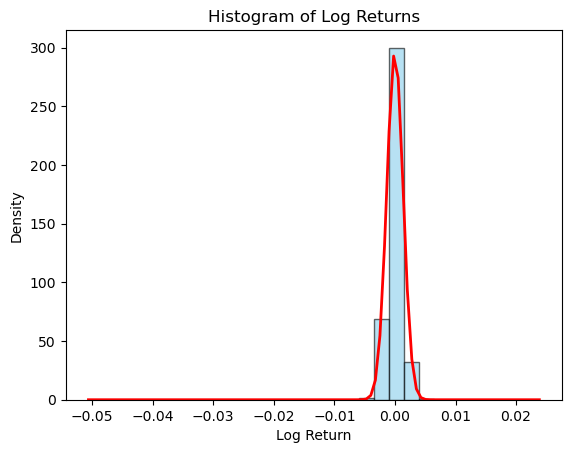

Shapiro-Wilk: {'statistic': 0.7528815080689434, 'p-value': 3.45772469018647e-81, 'normality': False}
Jarque-Bera: {'statistic': 45349767.126871504, 'p-value': 0.0, 'normality': False}
Ljung-Box: {'lag': 50, 'p-value': 3.056958573396282e-45, 'independence': False}


In [8]:
day1_product_df['adj_mid_price'] = day1_product_df.apply(calc_adj_mid_price_2, axis = 1)

# day1_product_df.plot(x='timestamp',y='mid_price')
# day1_product_df.plot(x='timestamp',y='adj_mid_price')
# plt.show()

mid_pirce_series = day1_product_df['adj_mid_price'].to_numpy()
return_series = np.diff(mid_pirce_series)
Log_price_series = log_series = np.log(mid_pirce_series)
log_return_series = np.diff(Log_price_series)
# plt.plot(np.diff(np.log(mid_pirce_series)))

test_results = check_gbm(mid_pirce_series[:])
for test, res in test_results.items():
    print(f"{test}: {res}")

In [ ]:
def calc_markov(time_series, scaling_factor=200):
    markov_trans_mat = np.zeros((int(max(time_series) * scaling_factor) - int(min(time_series) * scaling_factor) + 1,
                                 int(max(time_series) * scaling_factor) - int(min(time_series) * scaling_factor) + 1))
    markov_freq_mat = np.zeros((int(max(time_series) * scaling_factor) - int(min(time_series) * scaling_factor) + 1,
                                int(max(time_series) * scaling_factor) - int(min(time_series) * scaling_factor) + 1))

    for i in range(len(time_series) - 1):
        state_now = int(time_series[i] * scaling_factor) - \
            int(min(time_series) * scaling_factor)
        state_next = int(time_series[i + 1] * scaling_factor) - \
            int(min(time_series) * scaling_factor)
        markov_freq_mat[state_now][state_next] += 1

    markov_trans_mat = markov_freq_mat / (1.0 + i)

    return markov_trans_mat, markov_freq_mat

In [63]:
markov_trans_mat, markov_freq_mat = calc_markov(return_series[3000:], 1)

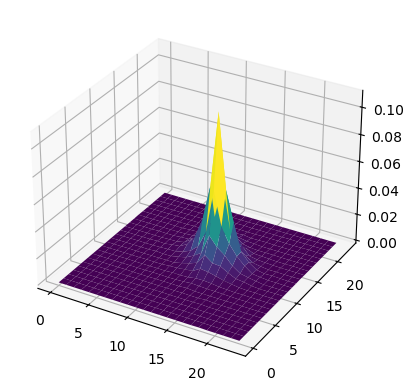

In [64]:
x, y = np.meshgrid(np.arange(markov_trans_mat.shape[1]), np.arange(
    markov_trans_mat.shape[0]))

# Plot the surface
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.plot_surface(x, y, markov_trans_mat, cmap='viridis')

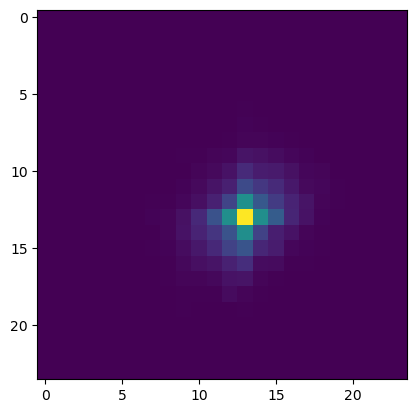

In [65]:
plt.imshow(markov_trans_mat)

In [88]:
def autocorrelation(series: np.array, lags):
    # 计算lags阶以内的自相关系数，返回lags个值，分别计算序列均值，标准差
    n = len(series)
    result = [np.correlate(series[i:]-series[i:].mean(), series[:n-i]-series[:n-i].mean())[0]
                / (series[i:].std()*series[:n-i].std()*(n-i))
                for i in range(1, lags+1)]
    return result

/var/folders/pp/zmh040gd59nfqh2pw782lv3m0000gn/T/ipykernel_44076/3768854152.py:4: RuntimeWarning: invalid value encountered in scalar divide
  result = [np.correlate(series[i:]-series[i:].mean(), series[:n-i]-series[:n-i].mean())[0]


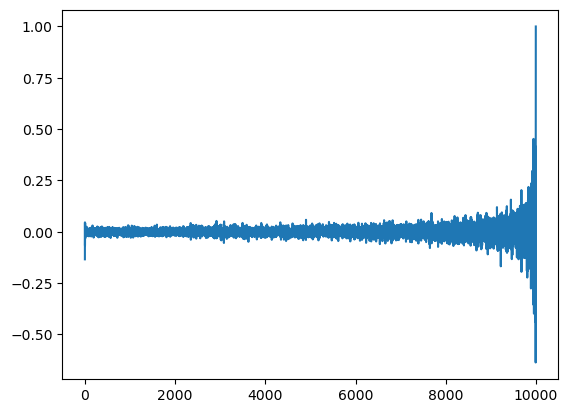

In [144]:
plt.plot(autocorrelation(log_return_series, len(log_return_series) - 1))